---

#  🟢 Plota Mapa do Acumulado de Focos de Calor para os 12 Meses de um Determinado Ano

---
**DADOS**:

 - Dados: Focos de calor do INPE na frequência anual - https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/EstadosBr_sat_ref/MG/

- Dados: Focos de calor do INPE na frequência mensal - https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/mensal/Brasil/


---
**REALIZAÇÃO**:


- Realizado por: Enrique V. Mattos - 04/09/2025
- E-mail: enrique@unifei.edu.br
- GitHub: https://github.com/evmpython
- Lattes: http://lattes.cnpq.br/8010078550088178


---






# **1° Passo:** Preparando ambiente

In [1]:
# instalações
!pip install -q ultraplot cartopy salem rasterio

# Bibliotecas para manipulação de arquivos e sistema
import glob                                 # Lista arquivos em diretórios usando padrões (ex: *.nc)
import time                                 # Medição de tempo de execução e operações relacionadas a tempo

# Bibliotecas para computação numérica e dados
import numpy as np                          # Operações matemáticas eficientes com arrays multidimensionais
import pandas as pd                         # Manipulação e análise de dados em estruturas tabulares (DataFrames)
import xarray as xr                         # Trabalho com arrays multidimensionais rotulados (comum em dados científicos)

# Bibliotecas para visualização de dados
import matplotlib.pyplot as plt             # Criação de gráficos e visualizações 2D/3D (biblioteca base)
import ultraplot as uplt                    # Visualização especializada para dados meteorológicos

# Bibliotecas para georreferenciamento e mapeamento
import cartopy                              # Ferramentas para criação de mapas e projeções cartográficas
import cartopy.crs as ccrs                  # Sistemas de referência de coordenadas para projeções de mapas
import cartopy.io.shapereader as shpreader  # Leitura de arquivos shapefile para mapas
import salem                                # Integração de dados geoespaciais com xarray
import os
from datetime import datetime
import calendar

# Controle de avisos
import warnings                             # Gerenciamento de mensagens de alerta durante a execução
warnings.filterwarnings("ignore")           # Supressão de avisos para manter a saída limpa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/ultraplot/__init__.py:77: UltraPlotWarning: Rebuilding font cache. This usually happens after installing or updating ultraplot.
  register_fonts(default=True)


# **2° Passo:** Declarando Funções

In [2]:
# Função que calcula o índice i e j da localização do foco de calor
def index(longitudes_matriz, latitudes_matriz, lon_foco, lat_foco):

    ''' Função para calcular o índice (i e j) do pixel de uma matriz que o relâmpago pertence

    Parâmetros:
               longitudes_matriz (array): array de uma dimensão das longitudes da matriz em graus
               latitudes_matriz (array): array de uma dimensão das latitudes da matriz em graus
               lon_raio (float): valor da longitude do foco em graus
               lat_raio (float): valor da latitude do foco em graus

    Retorna:
            indice_lat_raio (float): índice da latitude (ou seja, da linha) do pixel da matriz que o foco pertence
            indice_lon_raio (float): índice da longitude (ou seja, da coluna) do pixel da matriz que o foco pertence
    '''

    # calcula a diferença entre as lats/lons da matriz e a latitude/longitude do foco
    distancia_lon = (longitudes_matriz - lon_foco)**2
    distancia_lat = (latitudes_matriz - lat_foco)**2

    # índice da longitude e latitude do foco
    indice_lon_foco = np.nonzero(distancia_lon == np.min(distancia_lon))
    indice_lat_foco  = np.nonzero(distancia_lat == np.min(distancia_lat))

    # retorna os valores dos índices calculados
    return indice_lat_foco, indice_lon_foco

# **3° Passo:** Lendo os Dados do INPE

## Lendo os dados de 2003-2024
- São os dados por `ANO` do `Brasil` do satélite de referência `AQUA`.

In [3]:
%%time
# cria uma tabela vazia
df_2003_a_2024 = pd.DataFrame()

# FTP dos dados anual do satélite AQUA
url = 'https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/Brasil_sat_ref/'

# ano inicial e final: neste caso de 2003 a 2024
anoi, anof = '2003', '2025'

# loop dos meses
for ano in range(int(anoi), int(anof)):
    print(ano)

    # nome do arquivo
    filename = f'focos_br_ref_{str(ano)}.zip'

    # leitura da tabela: 2023
    df0 = pd.read_csv(f'{url}focos_br_ref_{str(ano)}.zip', compression='zip')

    # junta a tabela que foi lida com a anterior
    df_2003_a_2024 = pd.concat([df0, df_2003_a_2024], ignore_index=True)

# remove colunas
df_2003_a_2024.drop(['id_bdq','foco_id','pais'], axis=1, inplace=True)

# renomeia coluna
df_2003_a_2024.rename(columns={'data_pas': 'data'}, inplace=True)

# reposiciona as colunas
df_2003_a_2024 = df_2003_a_2024[['data','lat','lon','municipio','estado','bioma']]

# mostra o dataframe
df_2003_a_2024

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
CPU times: user 20.6 s, sys: 3.98 s, total: 24.6 s
Wall time: 1min 20s


,data,lat,lon,municipio,estado,bioma
0,2024-01-02 17:04:00,-15.89572,-38.89957,BELMONTE,BAHIA,Mata Atlântica
1,2024-01-02 17:06:00,-7.49188,-38.88316,BREJO SANTO,CEARÁ,Caatinga
2,2024-01-02 17:06:00,-6.50564,-39.44122,CARIÚS,CEARÁ,Caatinga
3,2024-01-02 17:06:00,-6.50409,-39.43422,CARIÚS,CEARÁ,Caatinga
4,2024-01-02 17:06:00,-5.74166,-39.59352,MOMBAÇA,CEARÁ,Caatinga
...,...,...,...,...,...,...
5107968,2003-09-26 16:30:00,-11.71700,-49.33000,DUERÉ,TOCANTINS,Cerrado
5107969,2003-09-26 18:08:00,-13.65700,-57.39400,DIAMANTINO,MATO GROSSO,Cerrado
5107970,2003-10-07 16:13:00,-5.87600,-44.64400,TUNTUM,MARANHÃO,Cerrado
5107971,2003-10-09 17:37:00,-12.27900,-60.48900,VILHENA,RONDÔNIA,Amazônia


## Lendo os dados de 2025
- São os dados por `MÊS` do `Brasil` de `TODOS` satélites.

In [4]:
%%time
# cria uma tabela
df_2025 = pd.DataFrame()

# FTP dos dados mensal de 2025 do satélite AQUA
url = 'https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/mensal/Brasil/'

# loop dos meses de 2025, de janeiro à setembro
for data in pd.date_range('20250101','20251001', freq='1M'):

    # extrai ano e mês
    ano = data.strftime('%Y')
    mes = data.strftime('%m')
    print(ano, mes)

    # nome do arquivo
    filename = f'focos_mensal_br_{ano}{mes}.csv'

    # leitura da tabela
    df0 = pd.read_csv(f'{url}{filename}')

    # junta a tabela que foi lida com a anterior
    df_2025 = pd.concat([df_2025, df0], ignore_index=True)

# seleciona apenas para MG e para o satélite de referência AQUA_M-T
#df_2025 = df_2025[ (df_2025['estado']=='MINAS GERAIS') & (df_2025['satelite']=='AQUA_M-T') ]
df_2025 = df_2025[ df_2025['satelite'] == 'AQUA_M-T' ]

# renomeia coluna
df_2025.rename(columns={'data_hora_gmt': 'data'}, inplace=True)

# reposiciona as colunas
df_2025 = df_2025[['data','lat','lon','municipio','estado','bioma']]

# mostra tabela
df_2025

2025 01
2025 02
2025 03
2025 04
2025 05
2025 06
2025 07
2025 08
2025 09
CPU times: user 5.85 s, sys: 659 ms, total: 6.51 s
Wall time: 26.6 s


,data,lat,lon,municipio,estado,bioma
1419,2025-01-01 16:52:00,-8.70136,-36.58537,CAPOEIRAS,PERNAMBUCO,Caatinga
1420,2025-01-01 16:52:00,-7.25636,-38.53855,BONITO DE SANTA FÉ,PARAÍBA,Caatinga
1421,2025-01-01 16:52:00,-7.60073,-37.72230,SOLIDÃO,PERNAMBUCO,Caatinga
1422,2025-01-01 16:52:00,-12.31578,-37.87934,ENTRE RIOS,BAHIA,Mata Atlântica
1423,2025-01-01 16:52:00,-12.30725,-37.89272,ENTRE RIOS,BAHIA,Mata Atlântica
...,...,...,...,...,...,...
1390123,2025-09-03 19:08:00,-3.20710,-60.60226,MANACAPURU,AMAZONAS,Amazônia
1390124,2025-09-03 19:08:00,-3.80178,-65.10154,ALVARÃES,AMAZONAS,Amazônia
1390125,2025-09-03 19:08:00,-5.27116,-60.41924,NOVO ARIPUANÃ,AMAZONAS,Amazônia
1390126,2025-09-03 19:08:00,-5.27282,-60.43021,NOVO ARIPUANÃ,AMAZONAS,Amazônia


## Junta os dados de 2003-2024 com 2025

In [5]:
# junta os dataframes
df = pd.concat([df_2003_a_2024, df_2025], ignore_index=True)

# transforma a coluna "datahora" para o formato "datetime"
df['data'] = pd.to_datetime(df['data'])

# seta a coluna "datahora" como o índice da tabela
df.set_index('data', inplace=True)

# ordena a tabela pelo índice
df.sort_index(inplace=True)

# mostra o dataframe final
df

,lat,lon,municipio,estado,bioma
data,,,,,
2003-01-01 16:04:00,-15.62100,-41.66500,BERIZAL,MINAS GERAIS,Mata Atlântica
2003-01-01 16:04:00,-15.27600,-41.51400,TREMEDAL,BAHIA,Mata Atlântica
2003-01-01 16:04:00,-14.82900,-40.13300,NOVA CANAÃ,BAHIA,Mata Atlântica
2003-01-01 16:05:00,-10.67500,-37.03400,ROSÁRIO DO CATETE,SERGIPE,Mata Atlântica
2003-01-01 16:05:00,-10.15600,-36.17400,CORURIPE,ALAGOAS,Mata Atlântica
...,...,...,...,...,...
2025-09-03 19:08:00,-5.13636,-62.54185,TAPAUÁ,AMAZONAS,Amazônia
2025-09-03 19:08:00,-3.43706,-59.56544,CAREIRO DA VÁRZEA,AMAZONAS,Amazônia
2025-09-03 19:08:00,-5.27282,-60.43021,NOVO ARIPUANÃ,AMAZONAS,Amazônia


# **4° Passo:** Acumula na Grade. Acumulado dos focos por mês para o Brasil e salvos em arquivos netcdf.

In [6]:
# mostra os dados que serão utilizados
df

,lat,lon,municipio,estado,bioma
data,,,,,
2003-01-01 16:04:00,-15.62100,-41.66500,BERIZAL,MINAS GERAIS,Mata Atlântica
2003-01-01 16:04:00,-15.27600,-41.51400,TREMEDAL,BAHIA,Mata Atlântica
2003-01-01 16:04:00,-14.82900,-40.13300,NOVA CANAÃ,BAHIA,Mata Atlântica
2003-01-01 16:05:00,-10.67500,-37.03400,ROSÁRIO DO CATETE,SERGIPE,Mata Atlântica
2003-01-01 16:05:00,-10.15600,-36.17400,CORURIPE,ALAGOAS,Mata Atlântica
...,...,...,...,...,...
2025-09-03 19:08:00,-5.13636,-62.54185,TAPAUÁ,AMAZONAS,Amazônia
2025-09-03 19:08:00,-3.43706,-59.56544,CAREIRO DA VÁRZEA,AMAZONAS,Amazônia
2025-09-03 19:08:00,-5.27282,-60.43021,NOVO ARIPUANÃ,AMAZONAS,Amazônia


Define o ano de processamento

In [7]:
%%time
# defina o ano
ano = '2025'

# verifica atual mês do ano atual
ano_atual = datetime.now().year
mes_atual = datetime.now().month

# Aplica a verificação apenas se o ano for o ano atual
if int(ano) == ano_atual:
    if mes_atual == 12:
        mes_mais_1 = mes_atual  # mantém 12
    else:
        mes_mais_1 = mes_atual #+ 1

    # Obtém o último dia do mês
    ultimo_dia = calendar.monthrange(ano_atual, mes_mais_1)[1]

# data inicial
data_i = f'{ano}0101'

# data final
data_f = f'{ano}{str(mes_mais_1).zfill(2)}{str(ultimo_dia).zfill(2)}'
print(data_i, data_f)

20250101 20250930
CPU times: user 273 µs, sys: 0 ns, total: 273 µs
Wall time: 277 µs


Plota figura

In [8]:
%%time

# Limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# Espaçamento da grade em graus
delta = 20/100.   # grade com 20 km de resolução espacial

# Montando a grade
lons = np.arange(lonmin, lonmax, delta)
lats = np.arange(latmax, latmin, -delta)

# Quantidade de pontos para longitude e latitude
nlon = len(lons)
nlat = len(lats)

# loop dos meses
for data in pd.date_range(data_i, data_f, freq='1M'):

    # estrai ano e mês
    ano = data.strftime('%Y')
    mes = data.strftime('%m')

    print('Processando ===>>>', f'{ano}-{mes}')

    # seleciona o mês
    df_selec = df.loc[f'{ano}-{mes}']

    # gera matriz de raios
    focos_lon, focos_lat = df_selec['lon'].values, df_selec['lat'].values

    # interpolando para ponto de grade
    focos = np.zeros((nlat, nlon))

    # loop em cada longitude e latitude da lista
    for lonfoco, latfoco in zip(focos_lon, focos_lat):

        # função que extrai a qual pixel aquele relâmpago pertence
        lin, col = index(lons, lats, lonfoco, latfoco)

        # soma os relâmpagos por pixel
        focos[lin,col]+=1

    # gera arquivo netcdf
    data_vars = {'focos':(('lat', 'lon'), focos, {'units': 'ocorrências/400km²', 'long_name':'Focos de Calor'})}
    coords = {'lat': lats, 'lon': lons, 'time': pd.to_datetime(f'{ano}-{mes}')}
    ds = xr.Dataset(data_vars=data_vars, coords=coords)
    ds.to_netcdf(f'focos_mensal_brasil_AQUA_{ano}{mes}.nc')

    print('Máximo por pixel', np.max(focos), '\n', 'Soma total', np.sum(focos), '\n')

Processando ===>>> 2025-01
Máximo por pixel 22.0 
 Soma total 3137.0 

Processando ===>>> 2025-02
Máximo por pixel 14.0 
 Soma total 1819.0 

Processando ===>>> 2025-03
Máximo por pixel 18.0 
 Soma total 2357.0 

Processando ===>>> 2025-04
Máximo por pixel 17.0 
 Soma total 1641.0 

Processando ===>>> 2025-05
Máximo por pixel 38.0 
 Soma total 4263.0 

Processando ===>>> 2025-06
Máximo por pixel 61.0 
 Soma total 6060.0 

Processando ===>>> 2025-07
Máximo por pixel 48.0 
 Soma total 9803.0 

Processando ===>>> 2025-08
Máximo por pixel 164.0 
 Soma total 18451.0 

Processando ===>>> 2025-09
Máximo por pixel 30.0 
 Soma total 2626.0 

CPU times: user 4.13 s, sys: 181 ms, total: 4.31 s
Wall time: 4.91 s


# **5° Passo:** Plota Figura

Processando ===>>> 0-2025-01
Processando ===>>> 1-2025-02
Processando ===>>> 2-2025-03
Processando ===>>> 3-2025-04
Processando ===>>> 4-2025-05
Processando ===>>> 5-2025-06
Processando ===>>> 6-2025-07
Processando ===>>> 7-2025-08
Processando ===>>> 8-2025-09


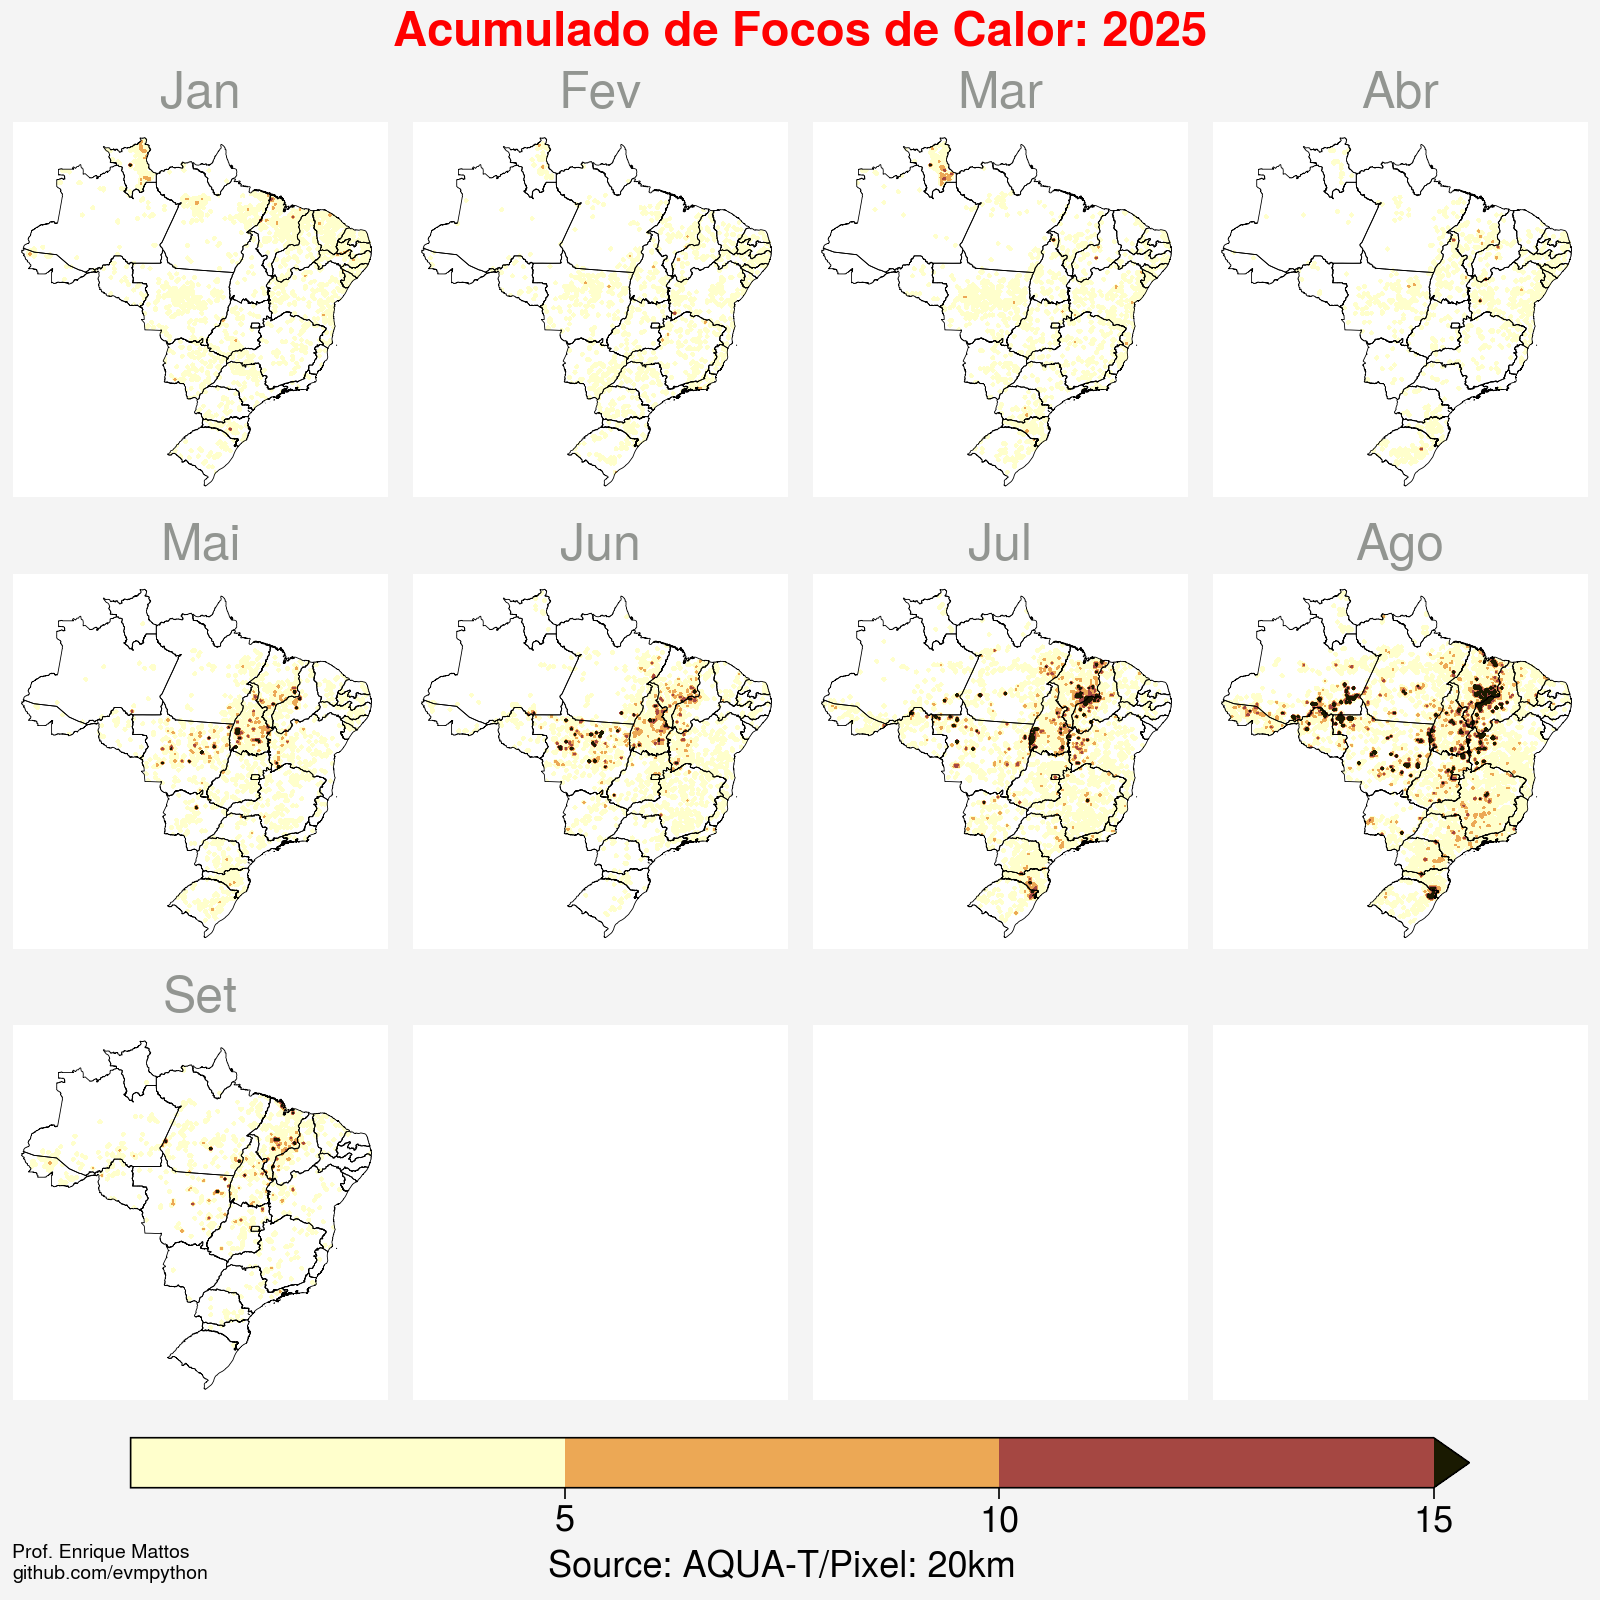

In [12]:
# Limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# leitura do shapefile do Brasil
shapefile_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')

# meses
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# cria a moldura da figura # (8, 12),
fig, ax = uplt.subplots(figsize=(8,8),
                        nrows=3, ncols=4,
                        tight=True,
                        proj='pcarree',
                        sharex=True, sharey=True)

# formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          small='20px', large='25px',
          linewidth=0, grid=False,
          suptitle=f'Acumulado de Focos de Calor: {ano}',
          suptitlecolor='red', suptitlesize=17)

# loop dos meses de 2024
for i, data in enumerate(pd.date_range(data_i, data_f, freq='1M')):

    # estrai ano e mês
    ano = data.strftime('%Y')
    mes = data.strftime('%m')

    # nome do arquivo
    arquivo_path = f'/content/focos_mensal_brasil_AQUA_{ano}{mes}.nc'

    print('Processando ===>>>', f'{i}-{ano}-{mes}')

    # Verifica se o arquivo existe antes de tentar abrir
    if not os.path.exists(arquivo_path):
        print(f'AVISO: Arquivo não encontrado: {arquivo_path}')
        print('Pulando para o próximo mês...')
        continue  # pula para a próxima iteração do loop
    try:
        # leitura dos arquivos
        ds = xr.open_dataset(arquivo_path)

        # plota figura
        map1 = ax[i].contourf(ds['lon'],
                              ds['lat'],
                              ds['focos'][:,:].salem.roi(shape=shapefile_brasil),
                              cmap='lajolla',
                              vmin=0.1, vmax=15,
                              levels=np.array([0.1, 5, 10, 15]),
                              extend='max')

        # plota titulo de cada figura
        mesint = int(mes)
        ax[i].format(title=f'{meses[mesint-1]}', labels = False, titleloc='c', titlecolor='grey')

        # shapefile dos estados
        shapefile = list(shpreader.Reader('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp').geometries())
        ax[i].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.3)
    except Exception as e:
        print(f"An error occurred while processing {arquivo_path}: {e}")

# informação na figura
ax[8].annotate('Prof. Enrique Mattos\ngithub.com/evmpython', xy=(lonmin,latmin-20.), fontsize=7, color='black')

# plota barra de cores da figura
fig.colorbar(map1,
             loc='b',
             label='Source: AQUA-T/Pixel: 20km',
             ticklabelsize=13,
             labelsize=13,
             length=0.85,
             width=0.25,
             space=0,
             ticks=[5, 10, 15],
             ticklabels=['5', '10', '15'])

# salva figura
fig.savefig(f'05_focos_mensal_{ano}_brasil.jpg', transparent=True, dpi=300, bbox_inches="tight")